In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from myfunctions import prediction_matrices

import warnings
warnings.filterwarnings("ignore")

In [26]:
df_train = pd.read_pickle('./data/df_train.pkl')
df_test = pd.read_pickle('./data/df_test.pkl')

# Assign Target and Features

In [27]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

In [28]:
df_train = df_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

# Logistic Regression

In [29]:
# Instatiate model and fit on train data

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

## Prediction scores and matrices

Report on train set : 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     11105
           1       0.85      0.87      0.86     13215

    accuracy                           0.85     24320
   macro avg       0.85      0.85      0.85     24320
weighted avg       0.85      0.85      0.85     24320

--------------------------------------------------------------------------------
Accuracy on test set: 0.85
ROC on test set: 0.95
Report on test set : 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      4860
           1       0.85      0.88      0.86      5536

    accuracy                           0.85     10396
   macro avg       0.85      0.85      0.85     10396
weighted avg       0.85      0.85      0.85     10396



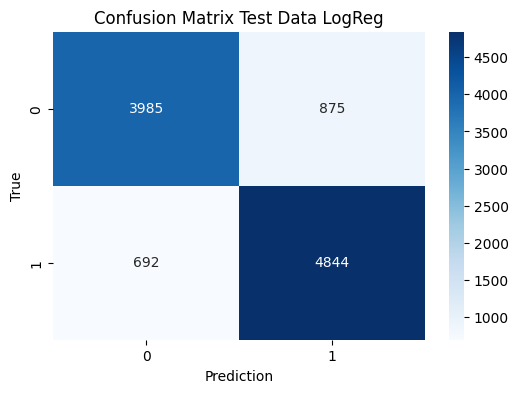

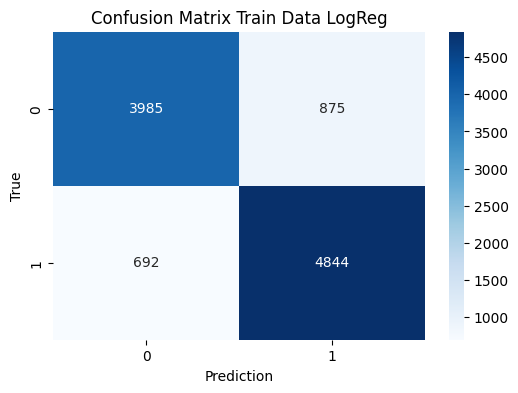

In [30]:
prediction_matrices(model = logreg, X_test = X_test, X_train= X_train, y_test= y_test, y_train = y_train, model_name= "LogReg")

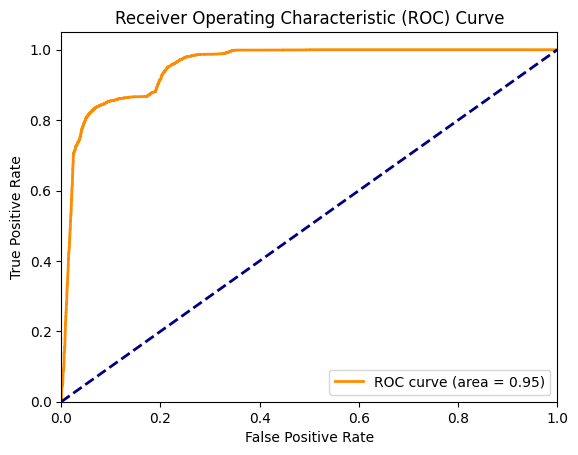

In [31]:
# ROC Curve
y_pred_roc = logreg.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



## Save Model

In [32]:
# Save model
with open('./model/model_logreg.pkl', 'wb') as file:
    pickle.dump(logreg, file)

## Feature Importance

Feature Importance:
                                        Feature  Importance
33               feedback_User Friendly Website    4.478648
30               feedback_Quality Customer Care    4.338921
31                    feedback_Reasonable Price    4.334934
29            feedback_Products always in Stock    4.315239
34                          membership_category    1.542112
4                              points_in_wallet    0.484218
8                                gender_Unknown    0.267394
27                feedback_Poor Product Quality    0.186488
26               feedback_Poor Customer Service    0.078349
16                     medium_of_operation_Both    0.077951
19                  internet_option_Mobile_Data    0.060411
11                      region_category_Village    0.060207
25                    complaint_status_Unsolved    0.053480
22              complaint_status_Not Applicable    0.052019
13                  joined_through_referral_Yes    0.041567
20                  

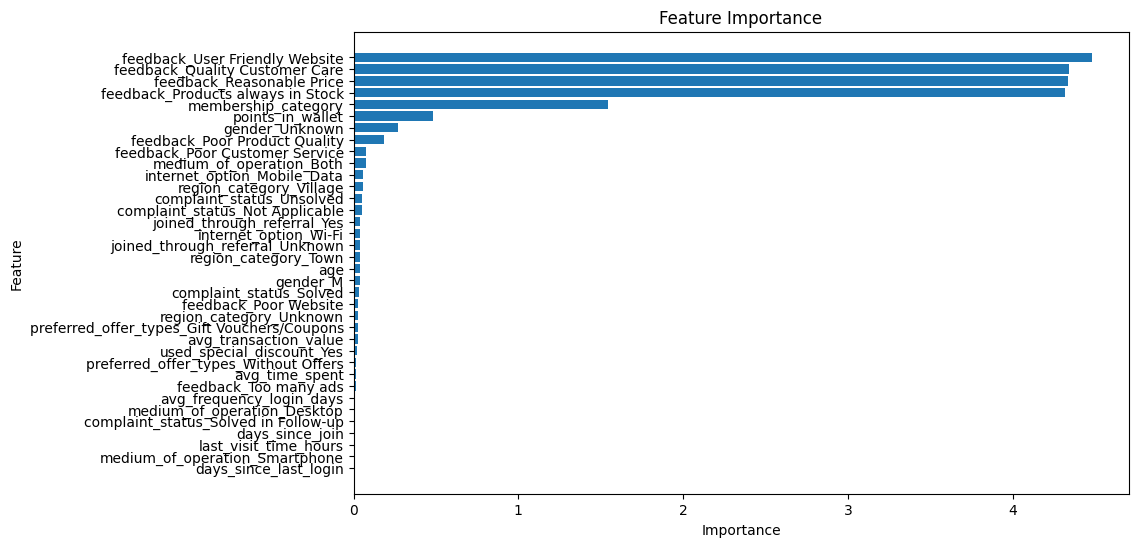

In [33]:
#feature importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': (coefficients)
    })
coefficients = coefficients.sort_values(by='Importance', ascending=False)
print(coefficients)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

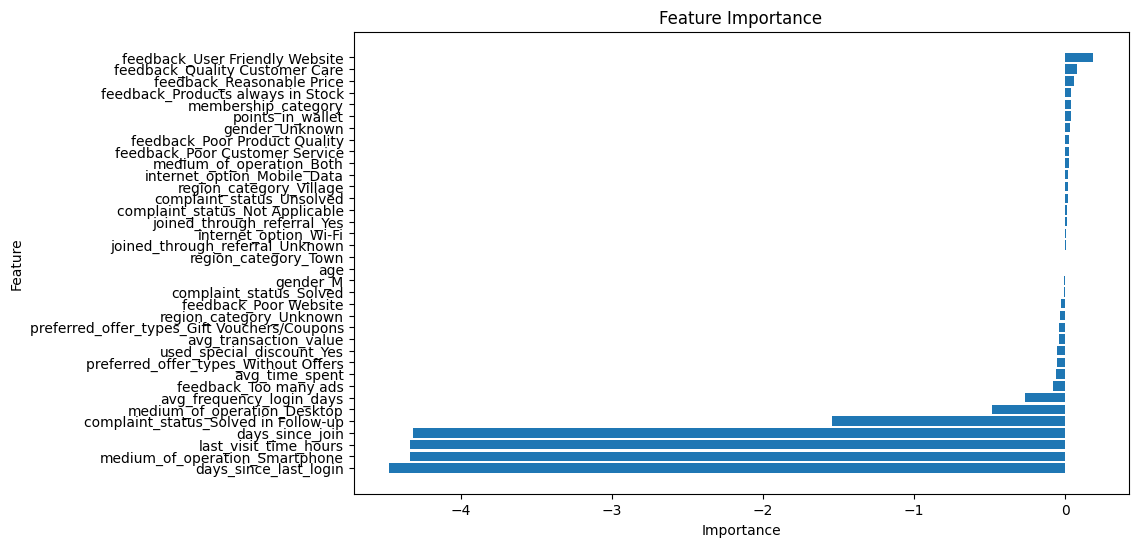

In [34]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], coefficients['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

In [35]:
# Erstellen Sie ein neues DataFrame, um die gesamte Wichtigkeit für jedes ursprüngliche Feature zu speichern
original_feature_importances = pd.DataFrame(columns=['Feature', 'Importance'])

for feature, group in feature_importance.groupby(feature_importance['Feature'].str.split('_').str[0]):
    total_importance = group['Importance'].sum()
    original_feature_importances = pd.concat([original_feature_importances, pd.DataFrame([{'Feature': feature, 'Importance': total_importance}])], ignore_index=True)

original_feature_importances = original_feature_importances.sort_values(by='Importance', ascending=False)

# Jetzt enthält `original_feature_importances` die gesamte Wichtigkeit für jedes ursprüngliche Feature
print(original_feature_importances)

       Feature  Importance
4     feedback   17.773207
10  membership    1.542112
11      points    0.484218
5       gender    0.303999
2    complaint    0.145126
13      region    0.126360
6     internet    0.101974
9       medium    0.087454
7       joined    0.082001
1          avg    0.052301
12   preferred    0.042732
0          age    0.037634
14        used    0.018933
3         days    0.007382
8         last    0.003896


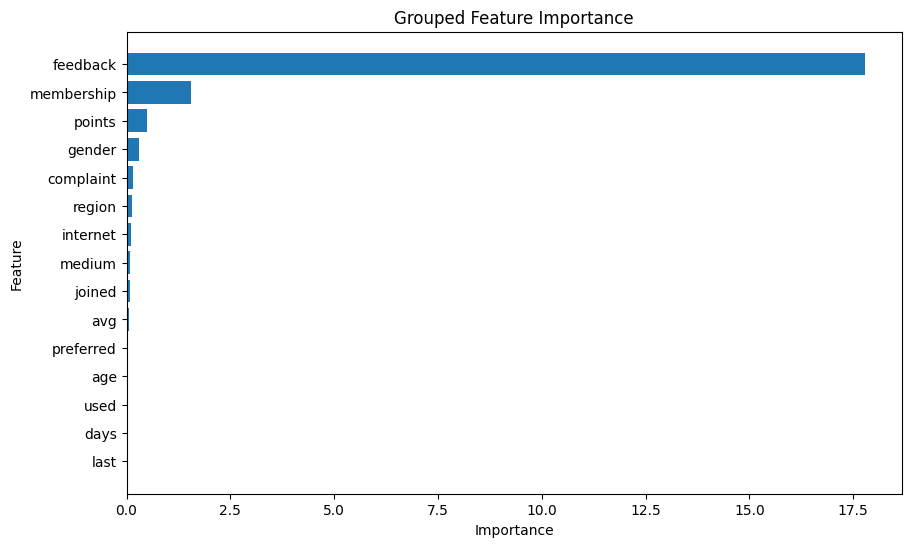

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(original_feature_importances['Feature'], original_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Grouped Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

# todo
- feature importance for dropped features during one-hot-encoding (does feature importance change when other categories of the same feature are dropped?)
- how to correctly aggregate one-hot-encoded features for feature importance: sum, mean?


In [37]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
y_pred = logreg.predict(X_test)
df_test_eval['y_pred'] = y_pred

In [38]:
# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
y_pred_train = logreg.predict(X_train)
df_train_eval['y_pred'] = y_pred_train

In [39]:
# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval.pkl')